In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context("paper", font_scale=1.6)
sns.set_style('whitegrid')

rndState = np.random.RandomState(12345)
from scipy.stats import spearmanr


In [3]:
np.__version__, sns.__version__, pd.__version__

('1.19.5', '0.11.1', '1.0.3')

In [5]:
class Cells():
    '''
    Simulates cellular protein production
    N_COPY = copy number of plasmid (around 50)
    random = random number. This also provides slight variation
            in the environment for each construct. So give a different
            number for each construct.
    construct = lower and upper limit of opening energy
                for the construct. This range should be low
                for granularity. eg: [10, 12]
    tolerance = cellular tolerance for the expressed protein, beyond
                which it becomes toxic and the cell may die
    favourable_oen = optimal opening energy. usually around 12.
    '''

    def __init__(self, random=12345,\
                    favourable_oen=12,\
                    tolerance=1000000,\
                    num_cells=100,\
                    construct=[2, 4]
                ):
        self.rndState = np.random.RandomState(random)
        self.N_COPY = self.rndState.randint(30, 60)
        self.favourable_oen = favourable_oen
        self.construct = construct
        self.num_cells = num_cells
        self.current_prot = 0
        self.n_mRNA = 0
        self.protein = 0
        self.tolerance = tolerance
        self.all_cells = []
        self.all_protein = []
        self.counter = 0

        
    
    def transcribe(self):
        '''
        transcibe DNA to mRNA
        '''
        self.n_mRNA = self.rndState.randint(0, self.N_COPY+1)

    def translate(self):
        '''
        generates opening energy for transcripts in the range
        defined in constructs as a list. eg [10, 12].
        Although optimum opening energy is given, make it a little 
        random so that sometimes higher opening energy is also 
        translated.
        '''
        if self.n_mRNA == 0:
            self.transcribe()
        
        self.oen_transcripts = self.rndState.uniform(self.construct[0], \
                                 self.construct[1], self.n_mRNA)
        fav_oen = self.favourable_oen + self.rndState.uniform(0, 30)

        # randomly decay mRNA after being translated greater than 10 times
        # http://book.bionumbers.org/how-many-proteins-are-made-per-mrna-molecule/
        mRNA_decay = self.rndState.randint(10, 100)
        protein = np.where(np.repeat(self.oen_transcripts, 3) <= fav_oen)
        self.protein = protein[0].size*mRNA_decay/3
        return self.protein

    def reproduce(self):
        if self.protein == 0:
            self.translate()
        if self.current_prot > self.tolerance:
            reproduction_rate = self.rndState.choice([-1, 0, 2])
        else:
            reproduction_rate = self.rndState.choice([0, 2])
        return reproduction_rate


    def start(self):
        current_prot = self.current_prot
        num_cells = self.num_cells
        if self.num_cells <= 0 or self.counter > 10000:
            if  self.counter > 10000:
                pass
#                 print('Max. iterations reached here.')
#             print('Max. protein for opening energy {} is {}.'.\
#                   format(np.mean(self.construct), current_prot))
            return (self.current_prot, self.num_cells)
        else:
            for i in range(self.num_cells + 1):
                self.transcribe()
                cell_prot = self.translate()
                cell_reprod = self.reproduce()
                if cell_reprod == -1:
                    #Don't add protein from this cell if it dies
                    current_prot = current_prot
                else:
                    current_prot += self.translate()
                num_cells += cell_reprod
                self.all_cells.append(num_cells)
                self.all_protein.append(current_prot)
                self.current_prot = current_prot
                self.num_cells = num_cells
                self.counter += 1

        self.start()

new = Cells()
new.start()

SpearmanrResult(correlation=-0.8107142857142855, pvalue=0.0002460079779722063)


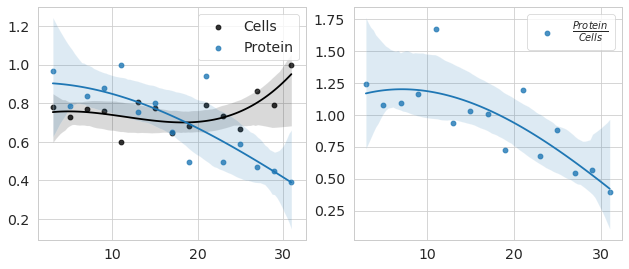

In [81]:
openens = [[i, i+2] for i in range(1, 32) if i%2 == 0]

df = pd.DataFrame(columns = ['Cells', 'Protein'], index=[int(np.mean(i)) for i in openens])

for i, v in enumerate(openens):
    new = Cells(construct=v, tolerance=1000000, random=i)
    new.start()
    df.loc[int(np.mean(v)), 'Cells'] = new.all_cells
    df.loc[int(np.mean(v)), 'Protein'] = new.all_protein

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
axes = ax.flatten()



sns.regplot(x=[int(np.mean(i)) for i in openens], \
             y=df['Cells'].apply(lambda x: x[-1])/max(df['Cells'].apply(lambda x: x[-1])),\
             color='black', label='Cells', ax=axes[0], order=3)
sns.regplot(x=[int(np.mean(i)) for i in openens],\
                y=df['Protein'].apply(max)/max(df['Protein'].apply(max)),\
                label='Protein', ax=axes[0], order=3)
axes[0].set_ylabel('')
axes[0].legend()

normalised_protein = (df['Protein'].apply(lambda x: x[-1])/max(df['Protein'].apply(lambda x: x[-1])))\
/(df['Cells'].apply(lambda x: x[-1])/max(df['Cells'].apply(lambda x: x[-1])))
sns.regplot(x=[int(np.mean(i)) for i in openens], y=normalised_protein, \
            label=r'$\frac{Protein}{Cells}$', order=3, ax=axes[1])
axes[1].legend()
plt.tight_layout()

print(spearmanr([i[1] for i in openens], normalised_protein,))

#### Plotting growth and unnormalised protein

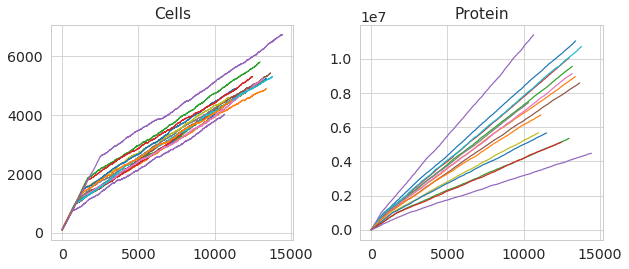

In [7]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
axes = ax.flatten()

for i, v in enumerate(df.columns):
    for p, q in enumerate(df[v]):
        sns.lineplot(x=np.arange(0, len(q)), y=q, ax=axes[i])
        axes[i].set_title(v)
    fig.tight_layout()


### Visualise cells with protein as fluorescence

In [82]:
min(df.Cells.apply(lambda x: x[-1])), max(df.Cells.apply(lambda x: x[-1]))

(4019, 6723)

In [83]:
min(df.Protein.apply(lambda x: x[-1])), max(df.Protein.apply(lambda x: x[-1]))

(4466562.0, 11397256.0)

/Volumes/userdata/student_users/bikashkumarbhandari/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


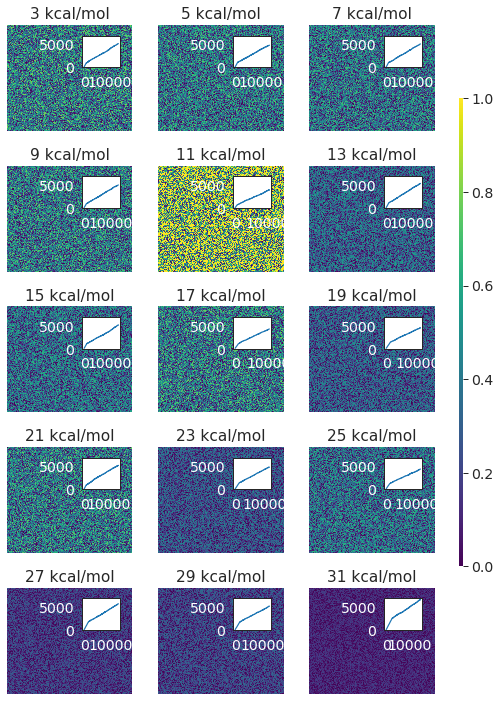

In [87]:
# fig, axn = plt.subplots(nrows=5, ncols=3, figsize=(8, 10), sharey=True, sharex=True)
fig, axn = plt.subplots(nrows=5, ncols=3, figsize=(6.5, 10), sharey=True, sharex=True)
cbar_ax = fig.add_axes([1, .2, .01, .65])

for i, ax in enumerate(axn.flat):
    newRand = np.random.RandomState(i)
    current_const = df.index[i]
    
    x = np.linspace(-1, 1, df.loc[current_const, 'Cells'][-1])
    y = newRand.uniform(-1, 1, df.loc[current_const, 'Cells'][-1])
    
    lums = newRand.random([df.loc[current_const, 'Cells'][-1], df.loc[current_const, 'Cells'][-1]])
    lums /= lums.sum()
    lums = lums*df.loc[current_const, 'Protein'][-1]

    for_pic = pd.DataFrame(lums)
    for_pic.columns = x
    for_pic.index = y
    
    sns.heatmap(for_pic[newRand.choice(x, 500)].loc[newRand.choice(y, 500)],\
                cmap='viridis', vmin=0, vmax=1, \
                cbar=i == 0,\
                cbar_ax=None if i else cbar_ax, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([]);
    ax.set_title('{} kcal/mol'.format(current_const));

    ## Inset to show growth
    sns.set_style('white')
    ins = ax.inset_axes([0.6, 0.6, 0.3, 0.3],)
    ins.plot(df.loc[current_const, 'Cells'])
    ins.set_ylim([0, 7000])
    ins.tick_params(axis='x', colors='white')
    ins.tick_params(axis='y', colors='white')

fig.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('Visualisation_cells.pdf', bbox_inches='tight', box_padding=None)


sns.set_style('whitegrid')

#### Spearman's correlation with iterations

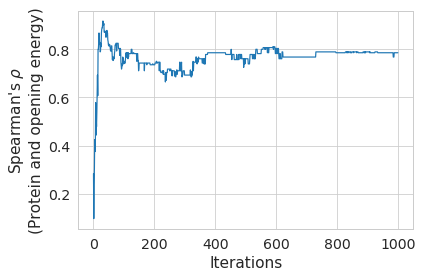

In [73]:
corrs = []

for itr in range(1000):
    normalised_cell = df['Cells'].apply(lambda x: x[itr])/max(df['Cells'].apply(lambda x: x[itr]))
    normalised_prot = df['Protein'].apply(lambda x: x[itr])/max(df['Protein'].apply(lambda x: x[itr]))
    corr = spearmanr(normalised_prot, df.index, )
    corrs.append(corr)

ax = sns.lineplot(x=np.arange(1000), y=[-i[0] for i in corrs])
ax.set_ylabel("Spearman's "+ r'$\rho$' + '\n(Protein and opening energy)')
ax.set_xlabel('Iterations');

#### Interactive

In [74]:
from ipywidgets import interact

def plot_all(itr=100):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes = ax.flatten()


    normalised_cell = df['Cells'].apply(lambda x: x[itr])/max(df['Cells'].apply(lambda x: x[itr]))
    normalised_prot = df['Protein'].apply(lambda x: x[itr])/max(df['Protein'].apply(lambda x: x[itr]))
    sns.regplot(x=df.index, y=normalised_cell, ax=axes[0], order=3)
    sns.regplot(x=df.index, y=normalised_prot, ax=axes[1], order=3)
    axes[0].set_xlabel('Opening Energy')
    axes[1].set_xlabel('Opening Energy')

    corr = spearmanr(normalised_prot, df.index, )

    plt.title('Protein vs OpenEn\nSpearmanr = {}\nP-value={}'.format(np.round(corr[0], 2), np.round(corr[1], 2)))

    fig.tight_layout();

interact(plot_all, itr=(0, 1000));

interactive(children=(IntSlider(value=100, description='itr', max=1000), Output()), _dom_classes=('widget-inte…

#### Simulate 3 times

In [75]:
normal = []

for r in range(3):
    df = pd.DataFrame(columns = ['Cells', 'Protein'], index=[np.mean(i) for i in openens])

    for i, v in enumerate(openens):
        new = Cells(construct=v, tolerance=1000000, random=r+i)
        new.start()
        df.loc[np.mean(v), 'Cells'] = new.all_cells
        df.loc[np.mean(v), 'Protein'] = new.all_protein
#     normalised_protein = (df['Protein'].apply(lambda x: x[-1])/max(df['Protein'].apply(lambda x:x[-1])))\
#     /(df['Cells'].apply(lambda x:x[-1])/max(df['Cells'].apply(lambda x:x[-1])))
    normalised_protein = df['Protein'].apply(lambda x: x[-1])/(df['Cells'].apply(lambda x:x[-1]))
    normal.append(normalised_protein)
    print(r+1, end='\r')

all_norm_df = pd.concat([pd.DataFrame(i) for i in normal])
all_norm_df = all_norm_df.reset_index()
all_norm_df['index'] = all_norm_df['index'].apply(int)
all_norm_df[0] = all_norm_df[0].apply(float)

SpearmanrResult(correlation=-0.7508428392552033, pvalue=2.8440625248176706e-09)


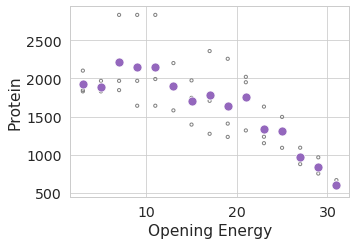

In [76]:

# # all_norm_df['Normalised'] 
# all_norm_df['Normalised Protein'] = (all_norm_df[0] - all_norm_df[0].mean())/all_norm_df[0].std()
print(spearmanr(all_norm_df['index'], all_norm_df[0]))


plt.figure(figsize=(5, 3.5))
sns.scatterplot(data=all_norm_df, x='index', y=all_norm_df[0], s=10, \
           facecolor='none', edgecolor='grey', linewidth=1)
ax = sns.lineplot(data=all_norm_df, x='index', y=all_norm_df[0],\
                  marker='o', markersize=9, linestyle='', ci=None, color='#9467BD')
ax.set_ylabel('Protein')
ax.set_xlabel('Opening Energy');
# plt.savefig('simulation.pdf', bbox_inches='tight')

